In [119]:
import qiskit
from qiskit import Aer
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector

import time

import numpy as np

import random

import gym
from gym import wrappers
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch import Tensor
from torch.nn import MSELoss
from torch.optim import LBFGS, SGD, Adam, RMSprop
import matplotlib.pyplot as plt

from collections import deque

from IPython import display

# Global Parameters

In [120]:
# PQC hyper parameters
NUM_QUBITS = 4 # num_states = num_qubits
NUM_ACTIONS = 2 # number of actions
REP = 2 # number of PQC blocks

In [121]:
# Training hyper parameters
EPISODES = 200  # number of episodes
EPS_START = 0.9  # e-greedy threshold start value
EPS_END = 0.05  # e-greedy threshold end value
EPS_DECAY = 200  # e-greedy threshold decay
GAMMA = 0.8  # Q-learning discount factor
LR = 0.001  # NN optimizer learning rate
BATCH_SIZE = 64  # Q-learning batch size

# Parametrized Quantum Circuit (PQC)

The PQC that encodes the policy for training.

In [122]:
def pqc(num_qubits, num_layers, insert_barriers=True):
    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)

    # input state params
    s_params = ParameterVector('s', num_qubits)

    # encoding params for training
    enc_params = ParameterVector('λ', 2*num_qubits*num_layers)

    # entangling params for training
    ent_params = ParameterVector('Φ', 2*num_qubits*num_layers)

    for l in range(num_layers):
        # construct add encoding layer
        for q in range(num_qubits):
            qc.ry(s_params[q] * enc_params[q + 2*num_qubits*l], q)
            qc.rz(s_params[q] * enc_params[q + 2*num_qubits*l + num_qubits], q)
        
        if insert_barriers: qc.barrier()

        # construct and add entangling layer
        for q in range(num_qubits):
            qc.ry(ent_params[q + 2*num_qubits*l], q)
            qc.rz(ent_params[q + 2*num_qubits*l + num_qubits], q)

        if insert_barriers: qc.barrier()

        # construct and add add circular entangler
        qc.cz(qr[-1], qr[0])
        for q in range(num_qubits-1):
            qc.cz(qr[q], qr[q+1])
        
        if insert_barriers: qc.barrier()
    
    return qc, s_params, enc_params, ent_params

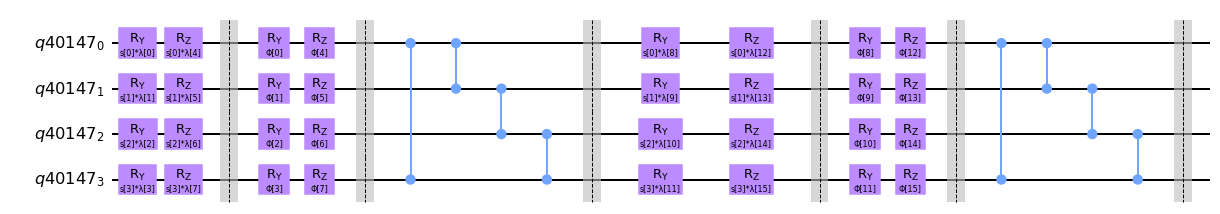

In [123]:
qc, s_params, enc_params, ent_params = pqc(NUM_QUBITS, REP)
qc.draw("mpl")

In [124]:
# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

# create a Quantum Neural Network object
qnn = CircuitQNN(qc, input_params=s_params, weight_params=[*ent_params, *enc_params], quantum_instance=qi_sv)

# connect to PyTorch
initial_weights = 2*np.random.rand(qnn.num_weights) - 1
quantum_nn = TorchConnector(qnn, initial_weights)

# Observable Layer

A layer that defines the way of extracting information from the circuit. It maps the projective measurement results into linear combination of Hermitian observables (could be extended to POVM).

In [125]:
# Raw VQC splitting qubits evenly for different actions.
class raw_split(torch.nn.Module):
    def __init__(self, num_qubits=NUM_QUBITS, num_actions=NUM_ACTIONS):
        super().__init__()
        assert num_qubits % num_actions == 0, "number of actions must divide number of qubits"

        # Define the weights for the layer
        weights = torch.Tensor(num_actions)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, *[35 for _ in range(num_actions)])

        # Define obeservables, splitting qubits evenly to each action
        mask_arrays = [np.zeros(2**num_qubits) for _ in range(num_actions)]
        action_qubits = num_qubits // num_actions
        for i in range(2**num_qubits):
            bs = list(format(i, f'0{num_qubits}b'))[::-1] #reverse to match qiskit endian
            for j in range(num_actions):
                maskj_bs = bs[j*action_qubits:(j+1)*action_qubits]
                parity = sum([int(b) for b in maskj_bs]) % 2
                mask_arrays[j][i] = -2*parity + 1 #0 -> 1, 1 -> -1
        self.masks = [torch.tensor(a, requires_grad=False) for a in mask_arrays]
    
    def forward(self, x):
        # single
        if len(x.shape) == 1:
            exps = [torch.sum(maskj*x) for maskj in self.masks]
            outputs = torch.cat(tuple(e.unsqueeze(0) for e in exps))
            return (self.weights * ((outputs + 1.) / 2.)).view(1, -1)
        # batch
        else:
            exps = [torch.sum(maskj*x, dim = 1, keepdim = True) for maskj in self.masks]
            outputs = torch.cat(tuple(exps), 1)
            return self.weights * ((outputs + 1.) / 2.)

In [126]:
observable_layer = raw_split(NUM_QUBITS, NUM_ACTIONS)

# Final Quantum Model

In [127]:
quantum_model = torch.nn.Sequential(quantum_nn, observable_layer)

# Train Cartpole-V1 with Quantum Policy

 Episode 0 finished after 15 steps


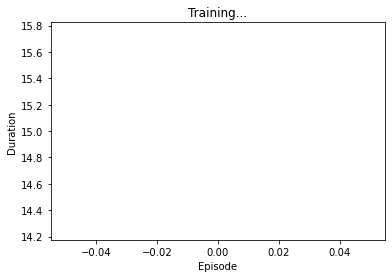

 Episode 1 finished after 35 steps


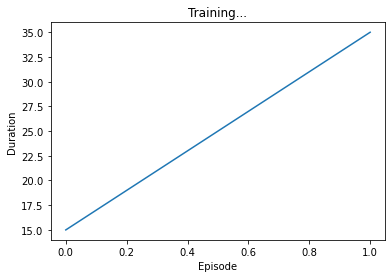

In [130]:
# if gpu is to be used
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        self.memory.append(transition)
        if len(self.memory) > self.capacity:
            del self.memory[0]

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, f'./tmp/cartpole-v0-1_{time.time()}')

model = torch.nn.Sequential(quantum_nn, observable_layer)
if use_cuda:
    model.cuda()
memory = ReplayMemory(10000)
optimizer = optim.Adam(model.parameters(), LR)
steps_done = 0
episode_durations = []

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return model(Variable(state).type(FloatTensor)).data.max(1)[1].view(1, 1)
    else:
        return LongTensor([[random.randrange(2)]])


def run_episode(e, environment):
    state = environment.reset()
    steps = 0
    while True:
        environment.render()
        action = select_action(FloatTensor([state]))
        next_state, reward, done, _ = environment.step(action[0, 0].item())

        # negative reward when attempt ends
        if done:
            reward = -1

        memory.push((FloatTensor([state]),
                     action,  # action is already a tensor
                     FloatTensor([next_state]),
                     FloatTensor([reward])))

        learn()

        state = next_state
        steps += 1

        if done:
            print("{2} Episode {0} finished after {1} steps"
                  .format(e, steps, '\033[92m' if steps >= 195 else '\033[99m'))
            episode_durations.append(steps)
            plot_durations()
            break


def learn():
    if len(memory) < BATCH_SIZE:
        return

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(BATCH_SIZE)
    batch_state, batch_action, batch_next_state, batch_reward = zip(*transitions)

    batch_state = Variable(torch.cat(batch_state))
    batch_action = Variable(torch.cat(batch_action))
    batch_reward = Variable(torch.cat(batch_reward))
    batch_next_state = Variable(torch.cat(batch_next_state))

    # current Q values are estimated by NN for all actions
    current_q_values = model(batch_state).gather(1, batch_action)
    # expected Q values are estimated from actions which gives maximum Q value
    max_next_q_values = model(batch_next_state).detach().max(1)[0]
    expected_q_values = batch_reward + (GAMMA * max_next_q_values)

    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(current_q_values, expected_q_values)

    # backpropagation of loss to NN
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated


for e in range(EPISODES):
    run_episode(e, env)

print('Complete')
env.render(close=True)
env.close()
plt.ioff()
plt.show()